# Solving Ax = b through different decompositions of A
### Comparision of the speed of solving Ax = b through qr, singular-value, and lu decompositions
In this example we use a specific format to A and b:
A = (a_{mn}) ∈ ℝ^{N×N} with
a^{mn} = \begin{cases} 
    \frac{1}{{m+n-1}}, & \text{if } m \leq n + 1 \\
    0, & \text{else}
\end{cases}


In [57]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.linalg import lu
import datetime

In [58]:
# helper method to calculate the times of the functions
def timing_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        wrapper.execution_times.append(execution_time)
        return result

    wrapper.execution_times = []
    return wrapper

## Solution 1: calculate the qr decomposition of A, and through that the solution x.

In [59]:
@timing_decorator
def assemble_A_and_b(size: int):
    matrix_A = np.eye(size, dtype=float)
    vector_B = np.arange(size, dtype=float)

    # create matrix A
    for i in range(size):
        for j in range(size):
            if i <= j + 1:
                matrix_A[i, j] = 1 / (i + j + 1)
            else:
                matrix_A[i, j] = 0

    # create vector b
    for i in range(size):
        vector_B[i] = np.sum(matrix_A[i])

    return matrix_A, vector_B

In [60]:
@timing_decorator
def qr_decomp(matrix_a: np.ndarray):
    # calculate and return the matrix Q and R for matrix A
    matrix_q = np.linalg.qr(matrix_a)[0]
    matrix_r = np.linalg.qr(matrix_a)[1]

    return matrix_q, matrix_r

In [61]:
@timing_decorator
def calculate_qTb(matrix_q: np.ndarray, vector_b: np.ndarray):
    # calculate and return Q^T * b
    return np.matmul(np.transpose(matrix_q), vector_b)

In [62]:
@timing_decorator
def backwards_substitution(matrix_r: np.ndarray, vector_b: np.ndarray):
    n = len(vector_b)
    vector_x = np.arange(n, dtype=float)

    # last entry of x is (last entry of b) / (r[n][n])
    vector_x[n - 1] = vector_b[n - 1] / matrix_r[n - 1][n - 1]

    # go through the other rows individually and calculate xi
    for i in range(n - 2, -1, -1):
        temp: int = 0
        for j in range(i + 1, n, 1):
            temp += matrix_r[i][j] * vector_x[j]
        vector_x[i] = (vector_b[i] - temp) / matrix_r[i][i]
    return vector_x

In [63]:
@timing_decorator
def calculate_solution_qr(matrix_a: np.ndarray, vector_b : np.ndarray):
    matrix_q = qr_decomp(matrix_a)[0]
    matrix_r = qr_decomp(matrix_a)[1]
    return backwards_substitution(matrix_q, calculate_qTb(matrix_q, vector_b))

## Solution 2: Calculating svd of A, then the solution is A^+ * b

In [64]:
@timing_decorator
def calculate_solution_svd(matrix_a: np.ndarray, vector_b : np.ndarray):
    return np.matmul(np.linalg.pinv(matrix_a), vector_b)

## Calculation the LR- decomposistion of A, and thus the solution x through backwards/forwards substitution

In [65]:
@timing_decorator
def lu_decomp(matrix_a: np.ndarray):
    matrix_p = lu(matrix_a)[0]
    matrix_l = lu(matrix_a)[1]
    matrix_r = lu(matrix_a)[2]
    return matrix_p, matrix_l, matrix_r

In [66]:
@timing_decorator
def forwards_substitution(matrix_L, vector_b):
    n = len(vector_b)
    x = np.zeros(n)
    
    for i in range(n):
        x[i] = (vector_b[i] - np.dot(matrix_L[i, :i], x[:i])) / matrix_L[i, i]
    
    return x

In [67]:
@timing_decorator
def calculate_solution_lu(matrix_a: np.ndarray, vector_b : np.ndarray):
    Pb = np.matmul(lu_decomp(matrix_a)[0], vector_b)
    y = forwards_substitution(lu_decomp(matrix_a)[1], Pb)
    x = backwards_substitution(lu_decomp(matrix_a)[2], y)

    return x

### step 4: calculating the times of each of the steps above

In [73]:
# execution time plotter

def plot_execution_times(matrix_sizes):
    # Lists to store execution times
    assembleAandB_times = []
    qrdecomp_times = []
    svddecomp_times = []
    ludecomp_times = []

    # Iterate over matrix sizes
    for N in matrix_sizes:
        # Create A and b according to the given size
        matrix_A, vector_B = assemble_A_and_b(N)

        # Assemble A and b and measure the execution time
        assemble_A_and_b(N)
        assembleAandB_times.append(assemble_A_and_b.execution_times[-1])

        # Measure the time for the solution through qr-decomposition for A
        calculate_solution_qr(matrix_A, vector_B)
        qrdecomp_times.append(calculate_solution_qr.execution_times[-1])

        # Measure the time for the solution through svd-decomposition for A
        calculate_solution_svd(matrix_A, vector_B)
        svddecomp_times.append(calculate_solution_svd.execution_times[-1])

        # Calculate the solution x through backwards substitution and measure the execution time.
        calculate_solution_lu(matrix_A, vector_B)
        ludecomp_times.append(calculate_solution_lu.execution_times[-1])

    # Plot execution times
    plt.plot(matrix_sizes, assembleAandB_times, label='assemble the matrix A and vector b')
    plt.plot(matrix_sizes, qrdecomp_times, label='qr decomposition solution of matrix a and vector b')
    plt.plot(matrix_sizes, svddecomp_times, label='svd decomposition solution of matrix a and vector b')
    plt.plot(matrix_sizes, ludecomp_times, label='lu decomposition solution of matrix a and vector b')
    plt.xlabel('Matrix size N')
    plt.ylabel('Execution Time (s)')
    plt.title('Name: Isik Baran Sandan, Date and Time: ' + datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    plt.legend()
    plt.show()

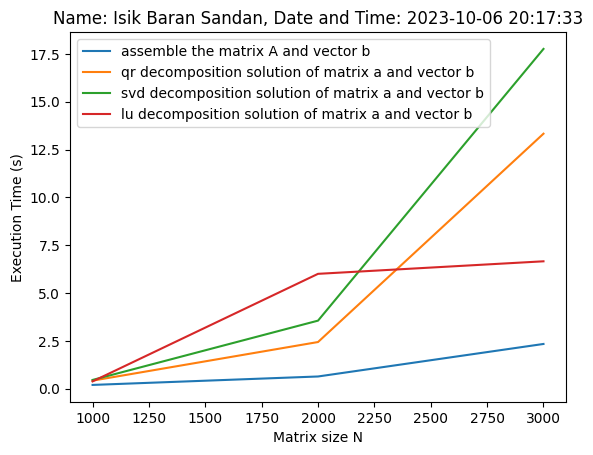

In [74]:
matrix_sizes = np.arange(1000,4000,1000)

plot_execution_times(matrix_sizes)